# ML Reglas de Precio Excelsior

Objetivo: Identificar características importantes para asignación de reglas de precio e incremento de Ingresos (Estimated Revenue)

Variables disponibles cualitativas:  
    - Día (Day)CONFIGURABLE  
    - Día de la semana (Weekday)  
    - Sitio (Site) CONFIGURABLE  
    - Tamaño de creativo (Creative Size) CONFIGURABLE  
    - Dispositivo (Device category) CONFIGURABLE  
    - País (Country) CONFIGURABLE  
    - Nombre Regla de Precio (pricing rule name)

Variables disponibles cuantitativas:  
    - Regla de Precio
    - Ad Requests.  
    - Matched Requests.  
    - Clicks.  
    - Estimated Revenue  
    - Ad Impressions  
    - Active View Enabled Impressions  
    - Active View measured Impressions  
    
$$eCPM = \frac{Ingresos}{Impresiones Vendidas} * 1000$$  
$$Fill Rate = \frac{Impresiones Vendidas}{Oportunidades}$$  
$$rCPM = \frac{Ingresos}{Oportunidades} * 1000 = eCPM * Fill Rate$$  
$$Viewability = \frac{Impresiones Vistas}{Impresiones Disponibles} * 1000$$

Target: Maximizar ingresos (revenue)  
Inputs: weekday, site, creative_size, device_category, country.  
Output: Regla de Precio.


In [5]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
from collections import Counter

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [6]:
# Carga de archivo base de datos con 9,994 registros, de los cuales información mensual desde Agosto 2020
import os
import tarfile
import urllib.request
import pandas as pd

PRULES_PATH = os.path.join("datasets")

def load_prules_data(prules_path=PRULES_PATH):
    csv_path = os.path.join(prules_path, "newbase_pricing_rules_open.csv")
    return pd.read_csv(csv_path)

# Carga y primera visualización de datos

In [7]:
# PARA PRIMERAS PRUEBAS Y ANÁLISIS DE COMPORTAMIENTO, TOMAMOS SOLAMENTE INFORMACIÓN DE EXCÉLSIOR.
# Visualización de la carga
target_site = 'Excelsior'

carga_prules = load_prules_data()
prules = carga_prules[carga_prules['site'] == target_site]

In [8]:
prules['rCPM'] = prules['revenue']/prules['ad_requests']*1000 #Modificar a eCPM
prules['FillRate'] = prules['ad_impressions']/prules['ad_requests']
prules['eCPM'] = prules['revenue']/prules['ad_impressions']*1000 #Modificar a eCPM
prules.head()

C:\Users\Aaron\AppData\Local\Temp\ipykernel_13852\811690050.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prules['rCPM'] = prules['revenue']/prules['ad_requests']*1000 #Modificar a eCPM
C:\Users\Aaron\AppData\Local\Temp\ipykernel_13852\811690050.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prules['FillRate'] = prules['ad_impressions']/prules['ad_requests']
C:\Users\Aaron\AppData\Local\Temp\ipykernel_13852\811690050.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

,day,weekday,site,creative_size,device,country,pricing_rules_name,pricing_rules,ad_requests,matched_ad_requests,clicks,revenue,ad_impressions,active_view_enabled_impressions,active_view_measured_impressions,rCPM,FillRate,eCPM
0,28/04/2022,jue,Excelsior,300x250,Desktop,United States,1 UPR Desktop USA,2.0,16,1,0,0.05,1,1,1,3.125000,0.062500,50.0
1,29/04/2022,vie,Excelsior,300x250,Desktop,United States,1 UPR Desktop USA,2.0,20,1,0,0.00,0,0,0,0.000000,0.000000,NaN
2,30/04/2022,sáb,Excelsior,300x250,Desktop,United States,1 UPR Desktop USA,2.0,13,1,0,0.00,0,0,0,0.000000,0.000000,NaN
3,01/05/2022,dom,Excelsior,300x250,Desktop,United States,1 UPR Desktop USA,2.0,25,2,0,0.12,2,2,2,4.800000,0.080000,60.0
4,03/05/2022,mar,Excelsior,300x250,Desktop,United States,1 UPR Desktop USA,2.0,21,2,0,0.03,2,2,2,1.428571,0.095238,15.0


In [9]:
prules = prules[prules['FillRate']<=1]
prules = prules.reset_index(drop = True)

Saving figure scatter_matrix_plot


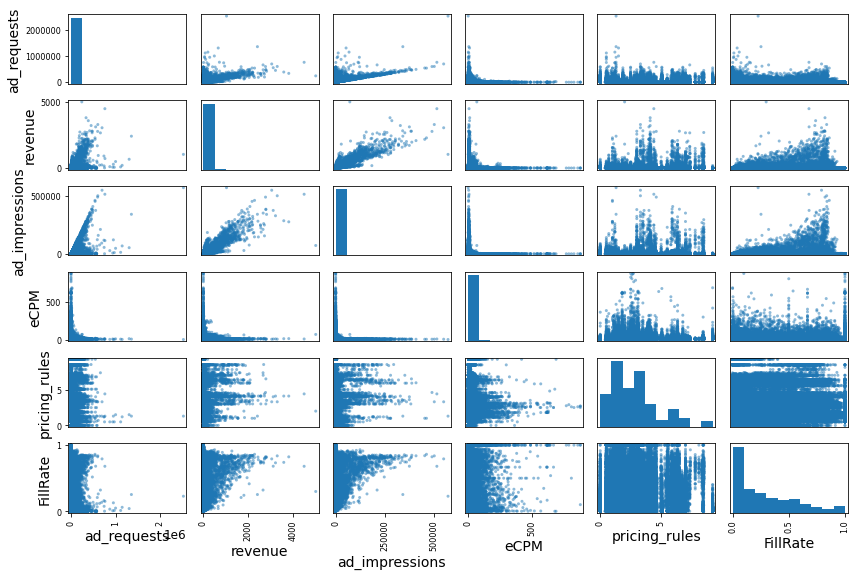

In [10]:
# from pandas.tools.plotting import scatter_matrix # For older versions of Pandas
# Todas las gráficas se ven muy dispersas
from pandas.plotting import scatter_matrix

attributes = ["ad_requests", "revenue", "ad_impressions",
              "eCPM", 'pricing_rules', 'FillRate']
scatter_matrix(prules[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

<AxesSubplot:>

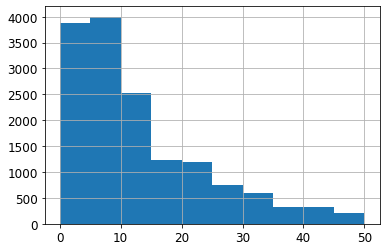

In [13]:
# Observar histograma por eCPM, si quitamos que sean mayor a 10, se irá la mitad de las instancias
prulesaux60 = prules[(prules['FillRate']>.60) & (prules['eCPM']<50)]
prulesaux60["eCPM"].hist()

Saving figure scatter_matrix_plot


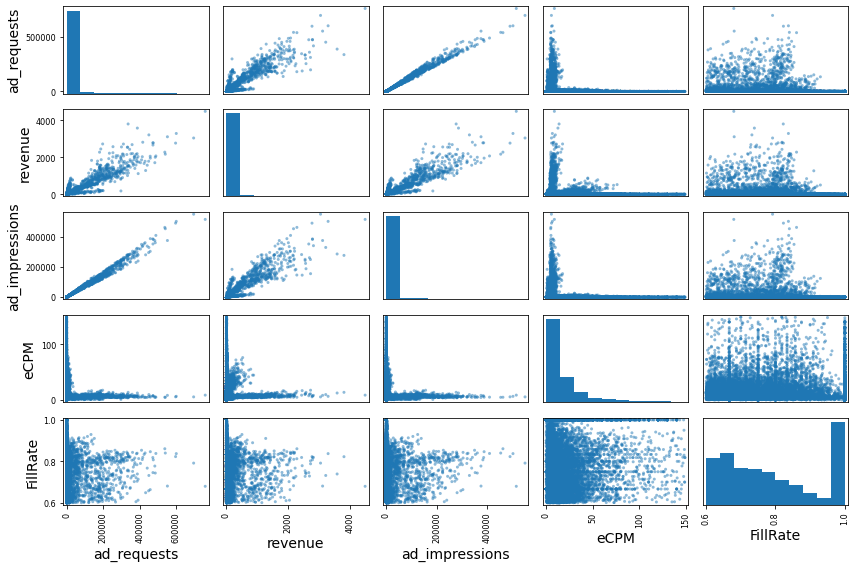

In [14]:
# Filtrando solamente las instancias que tienen Fill Rate superior a 60%.
# Se observan mejora en dispersión ad requests vs revenue.

prulesaux60 = prules[(prules['FillRate']>.60) & (prules['eCPM']<150)]
from pandas.plotting import scatter_matrix

attributes = ["ad_requests", "revenue", "ad_impressions", 'eCPM', 'FillRate']
scatter_matrix(prulesaux60[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

In [15]:
corr_matrix = prulesaux60.corr()
print(corr_matrix["revenue"].sort_values(ascending=False))
print('Registros: ',prulesaux60['day'].count())

revenue                             1.000000
ad_requests                         0.936363
ad_impressions                      0.933951
active_view_measured_impressions    0.933918
active_view_enabled_impressions     0.933873
matched_ad_requests                 0.932639
clicks                              0.859887
pricing_rules                       0.211050
eCPM                               -0.063030
rCPM                               -0.068143
FillRate                           -0.079913
Name: revenue, dtype: float64
Registros:  16252


(0.0, 800000.0, 0.0, 5000.0)

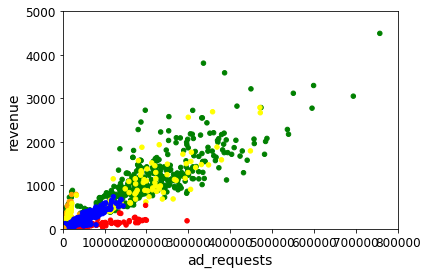

In [17]:
# Se observa que las instancias con mejor Fill Rate e ingresos son 
#prulesaux = prules[prules['creative_size'] == 'gen_amp']
colors = {'Sin Posicion':'orange', '300x250':'green', '728x90':'blue', '320x100':'yellow', 'Zocalo':'purple', '1x1':'orange', 'gen_amp':'red', '300x600':'orange', 'Tags':'orange', '320x50':'yellow', '300x100':'red', 'Native':'orange'}

prulesaux60.plot(kind="scatter", x="ad_requests", y="revenue", c= prulesaux60['creative_size'].map(colors))
plt.axis([0, 800000, 0, 5000])
#plt.yscale("log")

Saving figure scatter_matrix_plot


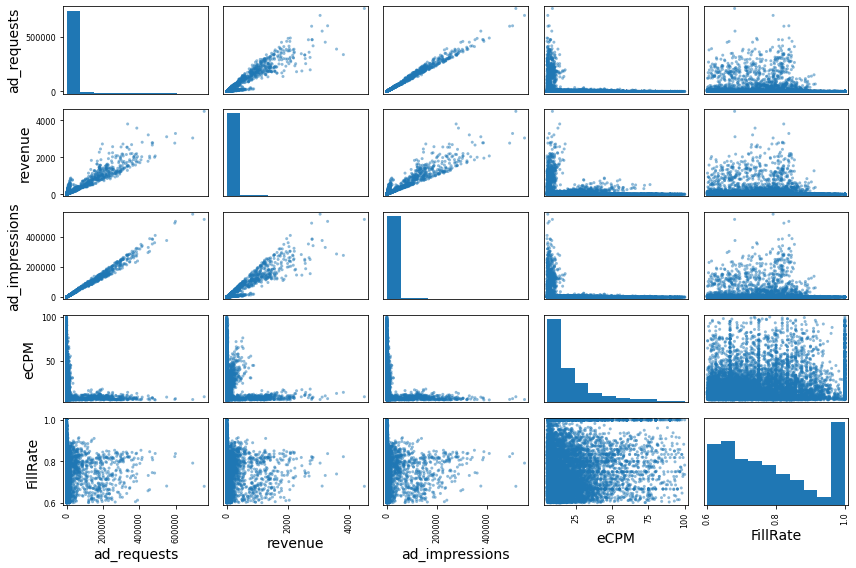

In [18]:
# Filtrando solamente las instancias que tienen Fill Rate superior a 60%.
# Se observam mejora en dispersión ad requests vs revenue.

prulesaux60 = prules[(prules['FillRate']>.60) & ((prules['eCPM']>5) & (prules['eCPM']<100))]
from pandas.plotting import scatter_matrix

attributes = ["ad_requests", "revenue", "ad_impressions", 'eCPM', 'FillRate']
scatter_matrix(prulesaux60[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

In [19]:
corr_matrix = prulesaux60.corr()
print(corr_matrix["revenue"].sort_values(ascending=False))
print('Registros: ',prulesaux60['day'].count())

revenue                             1.000000
ad_requests                         0.954284
active_view_enabled_impressions     0.949865
active_view_measured_impressions    0.949823
ad_impressions                      0.949778
matched_ad_requests                 0.948961
clicks                              0.873105
pricing_rules                       0.220457
FillRate                           -0.075995
eCPM                               -0.119196
rCPM                               -0.122222
Name: revenue, dtype: float64
Registros:  11616


(0.0, 800000.0, 0.0, 5000.0)

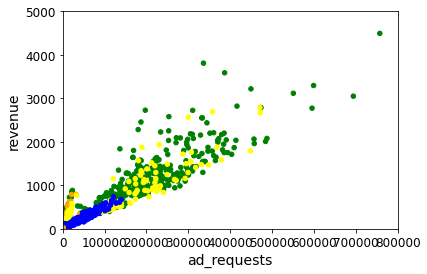

In [20]:
# Se observa que las instancias con mejor Fill Rate e ingresos son 
#prulesaux = prules[prules['creative_size'] == 'gen_amp']
prulesaux = prulesaux60
colors = {'Sin Posicion':'orange', '300x250':'green', '728x90':'blue', '320x100':'yellow', 'Zocalo':'purple', '1x1':'orange', 'gen_amp':'red', '300x600':'orange', 'Tags':'orange', '320x50':'yellow', '300x100':'red', 'Native':'orange'}

prulesaux.plot(kind="scatter", x="ad_requests", y="revenue", c= prulesaux['creative_size'].map(colors))
plt.axis([0, 800000, 0, 5000])
#plt.yscale("log")

## SE VA PRINCIPALMENTE LOS DE TAMAÑO 300x100 al filtrar con $5 CPMs. que aparece en el home desktop.

## A continuación, se esconde el análisis filtrando +70% fill rate, tomaremos 60% y eCPM superior a $5

In [37]:
prulesgb = prules.groupby('creative_size').sum()
#print(prulesgb.loc['1x1']['ad_impressions'])
prulesgb.head(20)

,pricing_rules,ad_requests,matched_ad_requests,clicks,revenue,ad_impressions,active_view_enabled_impressions,active_view_measured_impressions,rCPM,FillRate,eCPM
creative_size,,,,,,,,,,,
1x1,13.30,893031,10,0,0.01,6,6,6,0.000500,0.000188,10.000000
300x100,9606.84,153173507,32367669,32917,87967.58,24860793,24709018,24588076,3905.232991,665.430858,25774.782090
300x250,114817.31,502356715,162376587,1257864,1152330.02,116466237,116100473,115787539,170466.045601,10880.035236,646558.513495
300x600,9794.24,54051997,6224299,47517,116213.98,5760254,5749981,5735030,36818.456490,1023.092366,72006.342197
320x100,22640.43,166734243,32958056,287001,295507.02,28254979,28175458,28094987,15485.026943,941.358921,59700.495701
320x50,33773.80,35049718,20461741,69758,34904.92,7135628,7124881,7120932,13356.046351,1979.958017,81814.207990
728x90,89943.56,389520832,61208683,63699,306043.20,52656918,52608306,52500432,109397.669171,9611.190062,427150.203078
Native,539.85,906,337,0,0.56,238,238,238,129.761469,91.760739,285.166667
Sin Posicion,34370.21,8917254,3188167,10485,20784.99,1676893,1666783,1660842,228795.785530,6033.496764,423658.826765


In [42]:
(prulesgb.loc['300x250']['revenue']/prulesgb.loc['300x250']['ad_impressions']*1000)

9.894112230997898

In [51]:
def categorise(row,dfgb,porc):
    cpm_inst = row['eCPM'] # Se obtiene el CPM de la instancia
    c_size = row['creative_size'] # Se obtiene el creative_size de la instancia
    cpm_pond = (dfgb.loc[c_size]['revenue']/dfgb.loc[c_size]['ad_impressions']*1000) # Se obtiene el CPM general del creative size
    
    if cpm_inst > cpm_pond*porc: # Se compara cpm de la instancia vs cpm general del creative size
        return 1
    else:
        return 0 

In [60]:
prules['flag_cpm_sup'] = prules.apply(lambda row: categorise(row,prulesgb,.80), axis=1)


In [61]:
prulesaux60 = prules[(prules['FillRate']>.60) & ((prules['flag_cpm_sup']==1) & (prules['eCPM']<150))]
prulesgb60 = prulesaux60.groupby('creative_size').count()
#print(prulesgb.loc['1x1']['ad_impressions'])
prulesgb60['pricing_rules'].head(20)

creative_size
300x100          161
300x250         2970
300x600          788
320x100          335
320x50           284
728x90          3512
Native            11
Sin Posicion    2822
Name: pricing_rules, dtype: int64

In [62]:
corr_matrix = prulesaux60.corr()
print(corr_matrix["revenue"].sort_values(ascending=False))
print('Registros: ',prulesaux60['day'].count())

revenue                             1.000000
matched_ad_requests                 0.957654
active_view_enabled_impressions     0.952375
ad_impressions                      0.952329
active_view_measured_impressions    0.952309
ad_requests                         0.951807
clicks                              0.850970
pricing_rules                       0.153983
eCPM                               -0.086721
FillRate                           -0.087498
rCPM                               -0.092629
flag_cpm_sup                             NaN
Name: revenue, dtype: float64
Registros:  10883


Saving figure scatter_matrix_plot


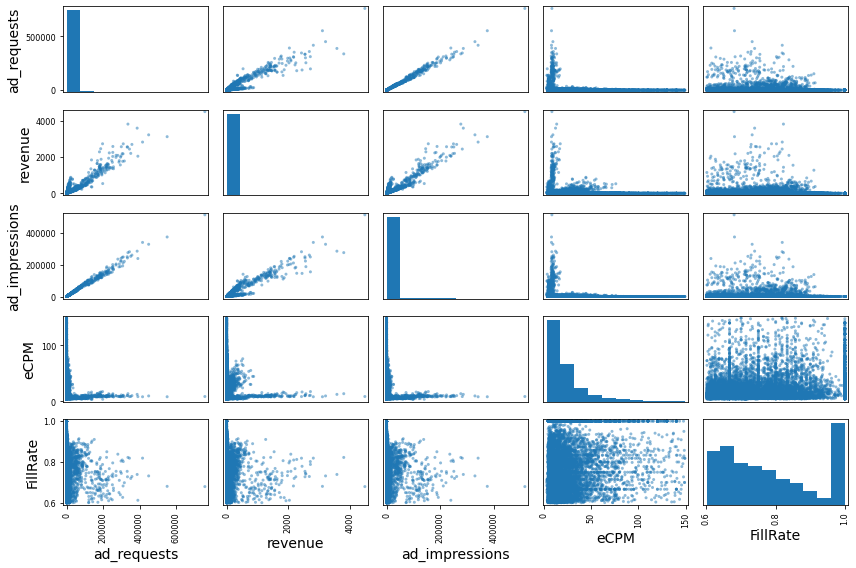

In [63]:
from pandas.plotting import scatter_matrix

attributes = ["ad_requests", "revenue", "ad_impressions", 'eCPM', 'FillRate']
scatter_matrix(prulesaux60[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

(0.0, 800000.0, 0.0, 5000.0)

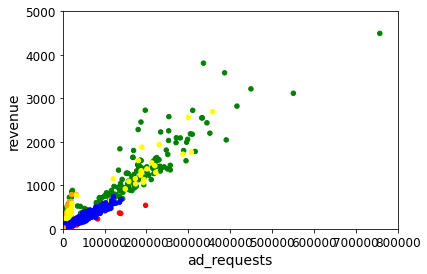

In [64]:
# Se observa que las instancias con mejor Fill Rate e ingresos son 
#prulesaux = prules[prules['creative_size'] == 'gen_amp']
prulesaux = prulesaux60
colors = {'Sin Posicion':'orange', '300x250':'green', '728x90':'blue', '320x100':'yellow', 'Zocalo':'purple', '1x1':'orange', 'gen_amp':'red', '300x600':'orange', 'Tags':'orange', '320x50':'yellow', '300x100':'red', 'Native':'orange'}

prulesaux.plot(kind="scatter", x="ad_requests", y="revenue", c= prulesaux['creative_size'].map(colors))
plt.axis([0, 800000, 0, 5000])
#plt.yscale("log")